# Squared Exponential kernel Gaussian Process
This is a demo notebook to compare ABC methods with PriorCVAE model on a Gaussian process dataset which is generated using a SquaredExponential kernel.
## PriorCVAE

In [2]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp

from priorCVAE_copy.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE_copy.priors import GP, SquaredExponential
from priorCVAE_copy.mcmc import run_mcmc_vae, vae_mcmc_inference_model, vae_hmc_inference_model
from priorCVAE_copy.datasets import GPDataset
from priorCVAE_copy.trainer import VAETrainer
from priorCVAE_copy.losses import SquaredSumAndKL
from priorCVAE_copy.utility import save_model_params, load_model_params

import jax.config as config
config.update("jax_enable_x64", True)

### Configuration

In [9]:
args = {
        "conditional": True,
        
        # architecture
        "input_dim" : 80,
        "hidden_dim": 60,
        "latent_dim": 40,
        
        # VAE training    
        "batch_size": 500,
        "num_iterations": 5000,
        "learning_rate": 1e-3,
        "vae_var": 1.,

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_mcmc_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
       }

### Generate data

We generate the data using an SquaredExponential kernel with lengthscale that is uniformly sampled. We plot a sample from the GP and plot the trajectories and lengthscales.

In [4]:
kernel = SquaredExponential()
gp_data_generator = GPDataset(n_data=args["input_dim"], kernel=kernel, sample_lengthscale=True)  

In [5]:
sample_x_train, sample_y_train, sample_ls_train = gp_data_generator.simulatedata(n_samples=1000)
x_test, y_test, ls_test = gp_data_generator.simulatedata(n_samples=1000)

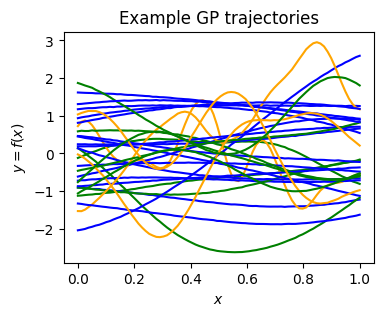

In [6]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(30):
    if sample_ls_train[i] <= 0.2:
        col = 'orange'
    elif sample_ls_train[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(sample_x_train[i], sample_y_train[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Example GP trajectories')
plt.show()

### PriorCVAE Model

We define the PriorCVAE model, optimizer, and initialize the parameters of the model randomly.

In [11]:
conditional = args["conditional"]
out_dim = args["input_dim"]
hidden_dim = args["hidden_dim"]
latent_dim = args["latent_dim"]
batch_size = args["batch_size"]
num_iterations  = args["num_iterations"]
true_ls = args["true_ls"]
learning_rate = args["learning_rate"]
vae_var = args["vae_var"]

In [12]:
encoder = MLPEncoder(hidden_dim, latent_dim)
decoder = MLPDecoder(hidden_dim, out_dim)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=learning_rate)
loss = SquaredSumAndKL(conditional=conditional, vae_var=vae_var)

### Train the model

Train the model and plot the train loss and the test loss.

In [13]:
trainer = VAETrainer(model, optimizer, loss=loss)
trainer.init_params(sample_y_train[0], c=sample_ls_train[0])

test_set = (x_test, y_test, ls_test)
loss_vals, test_vals, time_taken = trainer.train(gp_data_generator, test_set, num_iterations)

print(f'Training of {num_iterations} iterations took {round(time_taken)} seconds')

[    1] training loss: 8697.155, test loss: 76108.824
[   11] training loss: 5014.764, test loss: 53730.575
[   21] training loss: 5072.604, test loss: 46349.241
[   31] training loss: 4318.620, test loss: 40344.311
[   41] training loss: 3394.354, test loss: 34665.586
[   51] training loss: 3102.509, test loss: 29689.143
[   61] training loss: 2766.406, test loss: 26361.009
[   71] training loss: 2526.458, test loss: 23819.750
[   81] training loss: 2573.003, test loss: 22686.340
[   91] training loss: 2463.746, test loss: 21724.576
[  101] training loss: 1850.046, test loss: 20385.551
[  111] training loss: 2107.103, test loss: 20102.712
[  121] training loss: 2077.664, test loss: 19341.508
[  131] training loss: 1844.140, test loss: 19064.464
[  141] training loss: 1821.928, test loss: 18805.527
[  151] training loss: 2090.975, test loss: 18390.853
[  161] training loss: 1805.427, test loss: 18088.356
[  171] training loss: 1771.075, test loss: 17447.033
[  181] training loss: 1784.

In [14]:
args["model_path"] = f"output/{rnd.randint(0, 200)}"
save_model_params(args["model_path"], trainer.state.params)

### Trained Decoder

We plot a sample of trajectories from the trained decoder model.

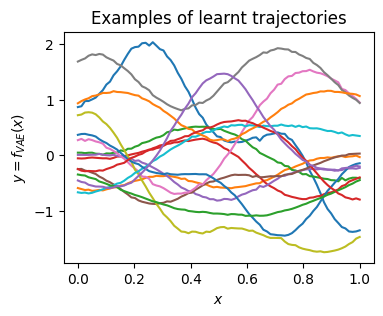

In [15]:
decoder_params = trainer.state.params['decoder']
key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (batch_size, latent_dim))
decoder = MLPDecoder(hidden_dim, out_dim)

c = true_ls * jnp.ones((z.shape[0], 1))
z_c = jnp.concatenate([z, c], axis=-1)
out = decoder.apply({'params': decoder_params}, z_c)             

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(sample_x_train[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

## Inference of Parameter-lengthscale

We randomly generate observations from the GP, one of lengthscale 0.25, the other of lengthscale 0.6

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.25and0.6')

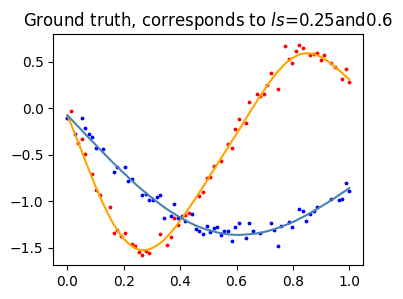

In [89]:
times = jnp.linspace(0, 1, 80)

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

kernel = SquaredExponential(lengthscale=0.25)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=times, jitter=1e-6, noise=True)

gp_draw_25 = draws['f'].T
y_draw_25 = draws['y'].T

obs_idx_25 = np.sort(np.random.permutation(80)[:60])
y_obs_25 = y_draw_25[obs_idx_25]
x_obs_25 = times[obs_idx_25]

kernel = SquaredExponential(lengthscale=0.6)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=times, jitter=1e-6, noise=True)

gp_draw_6 = draws['f'].T
y_draw_6 = draws['y'].T

obs_idx_6 = np.sort(np.random.permutation(80)[:60])
y_obs_6 = y_draw_6[obs_idx_6]
x_obs_6 = times[obs_idx_6]

plt.figure(figsize=(4,3))
plt.plot(times, gp_draw_25, label="ground truth", color="orange")
plt.scatter(x_obs_25, y_obs_25, color="red", label="observed data", s=3)
plt.plot(times, gp_draw_6, label="ground truth", color="steelblue")
plt.scatter(x_obs_6, y_obs_6, color="blue", label="observed data", s=3)
plt.title('Ground truth, corresponds to $ls$='+str(0.25)+'and'+str(0.6))

### Euclidean Distance
Simulate $z$ from the gaussian distribution, and compare $D(z,\theta)$ with our $y_{obs}$. Set $\hat{\theta} = min_{\theta} min_{z} ||D(z,\theta)-y_{obs}||^{2}$, and see how well it goes.

Try with 100,000 samples first.

In [105]:
key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (3000000, latent_dim))

decoder = MLPDecoder(hidden_dim, out_dim)
sample_ls = random.uniform(init_rng, (3000000,1))
c = sample_ls * jnp.ones((z.shape[0], 1))
z_c = jnp.concatenate([z, c], axis=-1)
out = decoder.apply({'params': decoder_params}, z_c)  

In [106]:
def distance(x):
    dist = np.sum(np.square(x[obs_idx_25]))[..., None] + np.sum(np.square(y_obs_25))[..., None] - 2 * np.dot(x[obs_idx_25],y_obs_25)                                                                                                    
    return dist
def distance_6(x):
    dist = np.sum(np.square(x[obs_idx_6]))[..., None] + np.sum(np.square(y_obs_6))[..., None] - 2 * np.dot(x[obs_idx_6],y_obs_6)                                                                                                    
    return dist

In [107]:
A = np.apply_along_axis(distance, 1, out).reshape(1,3000000)
idx = np.argpartition(A,1000)

In [108]:
B = np.apply_along_axis(distance_6, 1, out).reshape(1,3000000)
idx_6 = np.argpartition(B,1000)

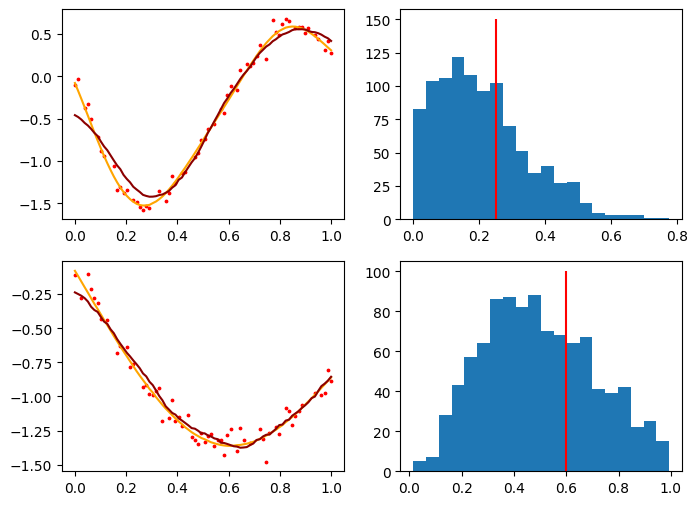

In [109]:
curve_25 = jnp.mean(out[idx[0][:1000],:],axis=0)
curve_6 = jnp.mean(out[idx_6[0][:1000],:],axis=0)

fig, axs = plt.subplots(2,2, figsize=(8,6))

axs[0,0].scatter(x_obs_25, y_obs_25, color="red", label="observed data", s=3)
axs[0,0].plot(times, gp_draw_25, label="ground truth", color="orange")
axs[0,0].plot(times, curve_25, color="darkred")

axs[0,1].hist(np.array(sample_ls[idx[0][:1000]]), 20)
axs[0,1].vlines(x=0.25, ymin=0, ymax=150, label='Actual value', color='red')


axs[1,0].scatter(x_obs_6, y_obs_6, color="red", label="observed data", s=3)
axs[1,0].plot(times, gp_draw_6, label="ground truth", color="orange")
axs[1,0].plot(times, curve_6, color="darkred")

axs[1,1].hist(np.array(sample_ls[idx_6[0][:1000]]), 20)
axs[1,1].vlines(x=0.6, ymin=0, ymax=100, label='Actual value', color='red')

# plt.title('Sample Result, corresponds to $ls$=' + str(mode_value))

### HMC Inference


In [110]:
import os
import time
import numpyro
import numpyro.distributions as npdist
from numpyro.infer import init_to_median, MCMC, NUTS

from priorCVAE_copy.mcmc import run_mcmc_vae, vae_mcmc_inference_model, vae_hmc_inference_model, run_hmc_vae

#### Attempt 1: with lengthscale = 0.25

In [111]:
args["y_obs"] = y_obs_25
args["obs_idx"] = obs_idx_25
# args["obs_idx"] = jnp.array(range(80))

In [103]:
mcmc_vae, mcmc_vae_samples, t_elapsed = run_hmc_vae(rng_key_post, vae_hmc_inference_model, args, decoder, decoder_params)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.72      0.18      0.73      0.47      1.00   7404.55      1.00
      f[0]     -0.43      0.04     -0.43     -0.50     -0.36  14364.96      1.00
      f[1]     -0.42      0.04     -0.42     -0.48     -0.35  14925.49      1.00
      f[2]     -0.41      0.04     -0.41     -0.47     -0.35  14565.12      1.00
      f[3]     -0.41      0.03     -0.41     -0.46     -0.35  14951.11      1.00
      f[4]     -0.40      0.03     -0.40     -0.45     -0.35  16507.33      1.00
      f[5]     -0.40      0.03     -0.40     -0.44     -0.35  16151.27      1.00
      f[6]     -0.39      0.03     -0.39     -0.44     -0.35  16085.40      1.00
      f[7]     -0.39      0.03     -0.39     -0.43     -0.34  16356.18      1.00
      f[8]     -0.39      0.02     -0.39     -0.43     -0.34  15709.77      1.00
      f[9]     -0.39      0.02     -0.39     -0.43     -0.35  15168.92      1.00
     f[10]     -0.39      0

Text(0.5, 1.0, 'PriorCVAE + HMC Inference')

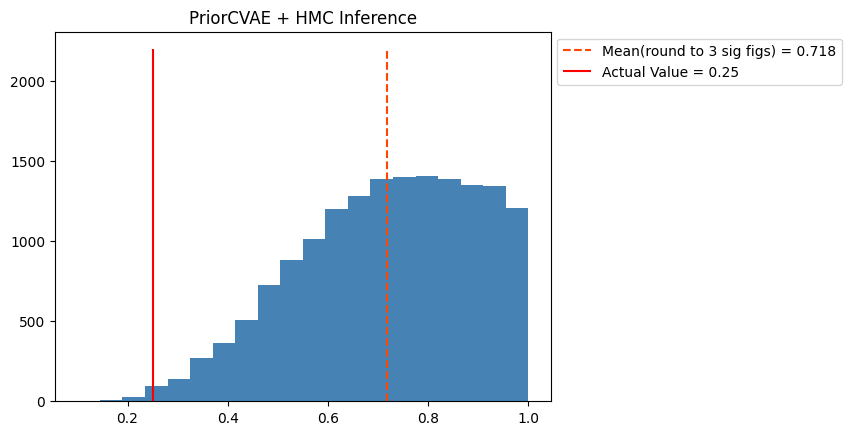

In [104]:
mean = jnp.mean(mcmc_vae_samples['c'])
plt.hist(mcmc_vae_samples['c'], 20, color='steelblue')
plt.vlines(x=jnp.mean(mcmc_vae_samples['c']), linestyles='dashed', ymin=0, ymax=2200, label='mean', color='orangered')
# plt.vlines(x=jnp.median(mcmc_vae_samples['c']), linestyles='dashed', ymin=0, ymax=2200, label='median', color='darkorange')
plt.vlines(x=0.25, ymin=0, ymax=2200, label='Actual value', color='red')
labels = ['Mean(round to 3 sig figs) = '+ str(round(mean, 3)), 'Actual Value = '+ str('0.25')]
plt.legend(labels, loc='best', bbox_to_anchor=(1.6, 1))
plt.title('PriorCVAE + HMC Inference')

#### Attempt 2: with lengthscale = 0.6

In [78]:
args["y_obs"] = y_obs_6
args["obs_idx"] = obs_idx_6

In [79]:
mcmc_vae, mcmc_vae_samples, t_elapsed = run_hmc_vae(rng_key_post, vae_hmc_inference_model, args, decoder, decoder_params)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         c      0.68      0.13      0.67      0.46      0.90   4373.02      1.00
      f[0]     -1.01      0.03     -1.01     -1.06     -0.97  11168.48      1.00
      f[1]     -1.00      0.02     -1.00     -1.04     -0.97  13635.46      1.00
      f[2]     -0.99      0.02     -0.99     -1.03     -0.96  12808.36      1.00
      f[3]     -0.99      0.02     -0.99     -1.02     -0.96  15127.75      1.00
      f[4]     -0.99      0.02     -0.99     -1.01     -0.96  17967.43      1.00
      f[5]     -0.99      0.02     -0.99     -1.01     -0.96  13982.01      1.00
      f[6]     -0.99      0.02     -0.99     -1.01     -0.96  12616.95      1.00
      f[7]     -0.99      0.02     -0.99     -1.02     -0.96  12906.63      1.00
      f[8]     -0.99      0.02     -0.99     -1.01     -0.96  11988.25      1.00
      f[9]     -0.99      0.02     -0.99     -1.02     -0.96  13113.27      1.00
     f[10]     -0.99      0

Text(0.5, 1.0, 'PriorCVAE + HMC Inference')

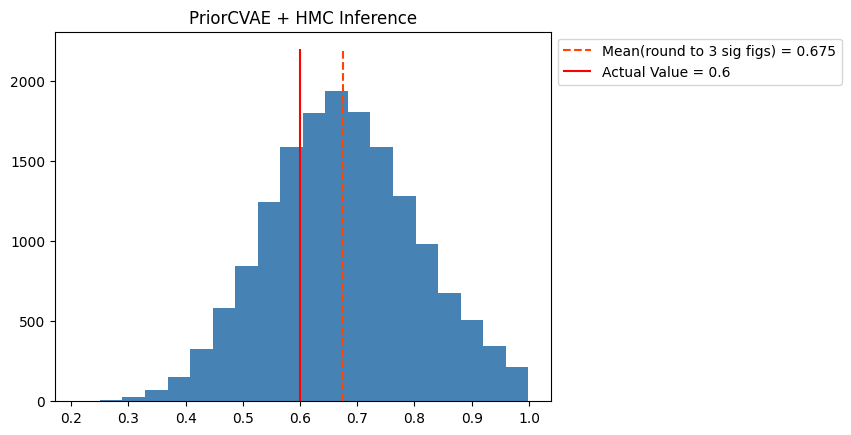

In [80]:
mean = jnp.mean(mcmc_vae_samples['c'])
plt.hist(mcmc_vae_samples['c'], 20, color='steelblue')
plt.vlines(x=jnp.mean(mcmc_vae_samples['c']), linestyles='dashed', ymin=0, ymax=2200, label='mean', color='orangered')
# plt.vlines(x=jnp.median(mcmc_vae_samples['c']), linestyles='dashed', ymin=0, ymax=2200, label='median', color='darkorange')
plt.vlines(x=0.6, ymin=0, ymax=2200, label='Actual value', color='red')
labels = ['Mean(round to 3 sig figs) = '+ str(round(mean, 3)), 'Actual Value = '+ str('0.6')]
plt.legend(labels, loc='best', bbox_to_anchor=(1.6, 1))
plt.title('PriorCVAE + HMC Inference')

Text(0.5, 1.0, 'PriorCVAE inference corresponding to $ls$=0.6')

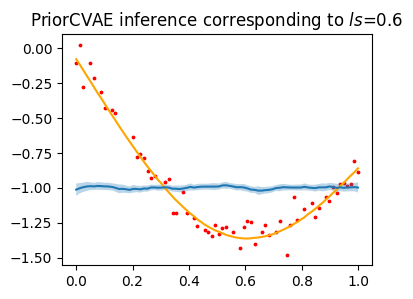

In [82]:
predictive = Predictive(vae_hmc_inference_model, mcmc_vae_samples)
predictions_vae = predictive(rng_key_preds, args, decoder, decoder_params)["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

plt.figure(figsize=(4,3))
plt.plot(times, gp_draw_6, label="ground truth", color="orange")
plt.scatter(x_obs_6, y_obs_6, color="red", label="observed data", s=3)
plt.title('Ground truth, corresponds to $ls$=' + str('0.6'))

plt.plot(times, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(times, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, label="VAE posterior: 90% BCI")

# y_min = min(np.concatenate([y_obs_6, mean_post_pred_vae, percentiles_vae[0, :]]))
# y_max = max(np.concatenate([y_obs_6, mean_post_pred_vae, percentiles_vae[1, :]]))

# plt.ylim([y_min, y_max])

plt.title('PriorCVAE inference corresponding to $ls$=' + str('0.6'))

In [75]:
def vae_c_inference_model(args=args, decoder=decoder, decoder_params=decoder_params):
    """
    VAE numpyro model used for running HMC inference, sampling `c`.

    :param args: a dictionary with the arguments required for MCMC.
    :param decoder: a decoder model.
    :param decoder_params: a dictionary with decoder network parameters.
    """

    z_dim = args["latent_dim"]
    y = args["y_obs"]
    obs_idx = args["obs_idx"]

    z = numpyro.sample("z", npdist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))  # (Z_dim,)
    c = numpyro.sample("c", npdist.Uniform()).reshape(1, )
    z = jnp.concatenate([z, c], axis=0)  # (Z_dim + C, )

    f = numpyro.deterministic("f", decoder.apply({'params': decoder_params}, z))
    sigma = numpyro.sample("sigma", npdist.HalfNormal(0.1))

    # if y is None:  # during prediction
    #     y_pred = numpyro.sample("y_pred", npdist.Normal(f, sigma))
    # else:  # during inference
    y = numpyro.sample("y", npdist.Normal(f[obs_idx], sigma), obs=y)

def run_c_vae(model: numpyro.primitives, rng_key=rng_key_post,args=args, decoder=decoder, decoder_params=decoder_params,
                 verbose: bool = True) -> [MCMC, jnp.ndarray, float]:
    """
    Run MCMC inference using VAE decoder.

    :param rng_key: a PRNG key used as the random key.
    :param model: a numpyro model of the type numpypro primitives.
    :param args: a dictionary with the arguments required for MCMC.
    :param decoder: a decoder model.
    :param decoder_params: a dictionary with decoder network parameters.
    :param c: a Jax ndarray used for cVAE of the shape, (N, C).
    :param verbose: if True, prints the MCMC summary.

    Returns:
        - MCMC object
        - MCMC samples
        - time taken

    """
    init_strategy = init_to_median(num_samples=10)
    kernel = NUTS(model, init_strategy=init_strategy)
    mcmc = MCMC(
        kernel,
        num_warmup=args["num_warmup"],
        num_samples=args["num_mcmc_samples"],
        num_chains=args["num_chains"],
        thinning=args["thinning"],
        progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True,
    )
    start = time.time()
    mcmc.run(rng_key, args, decoder, decoder_params)    # deleted `c` here
    t_elapsed = time.time() - start
    if verbose:
        mcmc.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", round(t_elapsed), "s")
    # ss = numpyro.diagnostics.summary(mcmc.get_samples(group_by_chain=True))
    # r = np.mean(ss['f']['n_eff'])
    # print("Average ESS for all VAE-GP effects : " + str(round(r)))

    return mcmc, mcmc.get_samples(), t_elapsed


## ABC on trained VAE
Sampling $z$ and $\theta$ from the gaussian/uniform prior.

In [115]:
import pints_jax
from pints_jax.toy import ToyModel
from pints_jax._error_measures import SumOfSquaresError, RootMeanSquaredError, RootMSE

In [84]:
decoder_params = trainer.state.params['decoder']

In [112]:
class VAEDecoder(ToyModel):
    def __init__(self,decoder_params):
        self._n_outputs = 1
        self._n_parameters = 41
        self.decoder_params = decoder_params

    def simulate(self, params, times):
        return decoder.apply({'params': self.decoder_params}, params)  

    def n_parameters(self):
        return self._n_parameters
    
    def n_outputs(self):
        return self._n_outputs

In [116]:
test_decoder = VAEDecoder(decoder_params)
test_problem = pints_jax.SingleOutputProblem(test_decoder, x_obs_25, values=y_obs_25)
error_measure = RootMSE(test_problem)

mean = np.zeros((40,1))
var = np.identity(40)
log_prior_1 = pints_jax.MultivariateGaussianLogPrior(mean,var)
log_prior_2 = pints_jax.UniformLogPrior(0,1)
log_prior = pints_jax.ComposedLogPrior(log_prior_1, log_prior_2)
abc = pints_jax.ABCController(error_measure, log_prior)

# set threshold schedule
abc.sampler().set_threshold(0.4)

# set target number of samples
abc.set_n_samples(800)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples_vae  = abc.run()
print('Done')

/var/folders/cg/0j2cykzn1nz90v77l0w8jyhc0000gv/T/ipykernel_47030/2167548734.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior_2 = pints_jax.UniformLogPrior(0,1)


Running...
Using Rejection ABC
Running in sequential mode.


ValueError: cannot reshape array of size 80 into shape (60,)

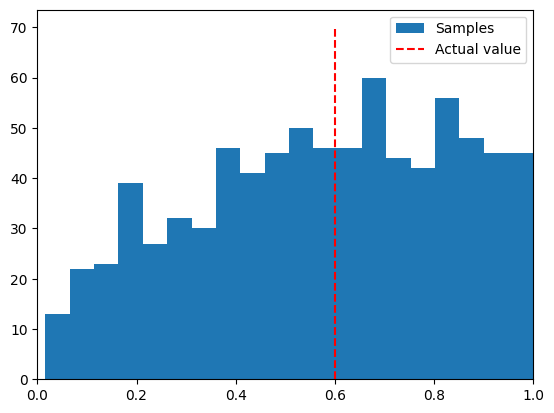

In [ ]:
plt.hist([x[40] for x in samples_vae[0:]], bins=20, label='Samples')
plt.xlim(0, 1)
plt.vlines(x=0.6, linestyles='dashed', ymin=0, ymax=70, label='Actual value', color='red')
plt.legend()
plt.show()

In [ ]:
test_decoder = VAEDecoder(decoder_params)
test_problem = pints_jax.SingleOutputProblem(test_decoder, times, values=y_obs)
error_measure = RootMSE(test_problem)

mean = np.zeros((40,1))
var = np.identity(40)
log_prior_1 = pints_jax.MultivariateGaussianLogPrior(mean,var)
log_prior_2 = pints_jax.UniformLogPrior(0,1)
log_prior = pints_jax.ComposedLogPrior(log_prior_1, log_prior_2)
# abc = pints_jax.ABCController(error_measure, log_prior,)
abc = pints_jax.ABCController(error_measure, log_prior, method=pints_jax.ABCSMC)

# set threshold schedule
abc.sampler().set_threshold_schedule([0.2,0.17,0.14])

# produce intermediate distributions of size 200
# abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(800)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples_tired  = abc.run()
print('Done')

/var/folders/cg/0j2cykzn1nz90v77l0w8jyhc0000gv/T/ipykernel_59231/1117128782.py:8: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior_2 = pints_jax.UniformLogPrior(0,1)


Running...
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=0.2
Iter. Eval. Acceptance rate Time m:s
1     57     0.0175438596     0:00.2
2     634    0.00315457413    0:01.5
3     1071   0.00280112045    0:02.5
20    4562   0.00438404209    0:10.0
40    10633  0.00376187341    0:23.1
60    17398  0.00344867226    0:38.1
80    25209  0.00317346979    0:55.4
Starting t=1, with threshold=0.17
100   28447  0.00351530917    1:02.5
120   28489  0.00421215206    1:02.6
140   28532  0.00490677134    1:02.8
160   28581  0.00559812463    1:03.0
180   28629  0.00628733103    1:03.2
Starting t=2, with threshold=0.14
200   28676  0.00697447343    1:03.6
220   32398  0.00679054263    1:19.5
240   36792  0.00652315721    1:37.4
260   40380  0.0064388311     1:51.5
280   43922  0.00637493739    2:06.3
300   49533  0.00605656835    2:29.7
320   53067  0.00603011288    2:44.4
340   59090  0.00575393468    3:08.0
360   63788  0.00564369474    3:26.2
380   68128  0.00557773603    3:

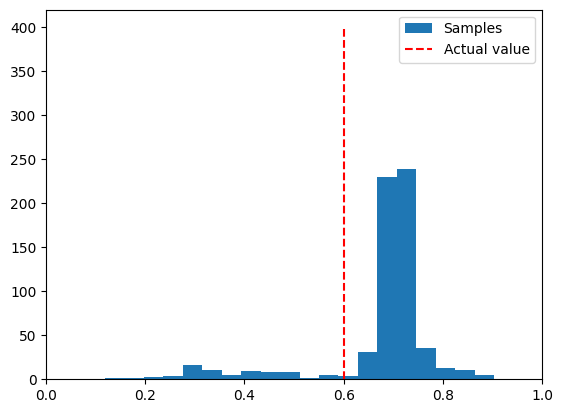

In [ ]:
plt.hist([x[40] for x in samples_tired[160:]], bins=20, label='Samples')
plt.xlim(0, 1)
plt.vlines(x=0.6, linestyles='dashed', ymin=0, ymax=400, label='Actual value', color='red')
plt.legend()
plt.show()

I feel the ABC results are very unstable when choosing different thresholds. It seems that we need ABC SMC to start with a small threshold, and then take larger gaps between each threshold. Sometimes it is even not the case that better results are achieved with smaller thresholds. --a bit confusing.

## ABC Rejection Sampling

In [ ]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

import random as rnd
import numpy as np 
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)

import jax
import optax
from jax import random
import jax.numpy as jnp

import jax.config as config
config.update("jax_enable_x64", True)

from priorCVAE_copy.priors import GP, SquaredExponential

import pints_jax
from pints_jax.toy import GaussianProcess
from pints_jax import RootMSE

In [ ]:
model = GaussianProcess(n_data=80)  

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

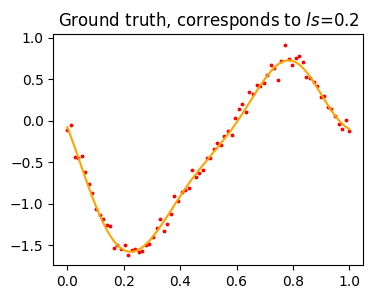

In [ ]:
times = jnp.linspace(0, 1, 80)
rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

kernel = SquaredExponential(lengthscale=0.2, variance=1.)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=times, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

plt.figure(figsize=(4,3))
plt.plot(times, gp_draw, label="ground truth", color="orange")
plt.scatter(times, y_draw, color="red", label="observed data", s=3)
plt.title('Ground truth, corresponds to $ls$=' + str(0.2))

In [ ]:
problem = pints.SingleOutputProblem(model, times, values=y_draw)
error_measure = RootMSE(problem)
log_prior = pints_jax.UniformLogPrior(0, 1)
abc = pints_jax.ABCController(error_measure, log_prior)
# abc = pints_jax.ABCController(error_measure, log_prior, method=pints_jax.ABCSMC)

# set threshold schedule
abc.sampler().set_threshold(0.55)

# produce intermediate distributions of size 200
# abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(800)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples_rej  = abc.run()
print('Done')

/var/folders/3z/d020c1ln2rbdn3rrr_x9nwxh0000gn/T/ipykernel_6156/615358625.py:4: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints_jax.UniformLogPrior(0, 1)


Running...
Using Rejection ABC
Running in sequential mode.
Iter. Eval. Acceptance rate Time m:s
1     139    0.0071942446     0:00.5
2     813    0.0024600246     0:02.2
3     1215   0.0024691358     0:03.3
20    10026  0.00199481348    0:25.8
40    18430  0.00217037439    0:47.2
60    28645  0.00209460639    1:12.2
80    38304  0.00208855472    1:35.8
100   46500  0.00215053763    1:55.6
120   57634  0.00208210431    2:22.0
140   68982  0.00202951495    2:48.5
160   84037  0.00190392327    3:24.3
180   92554  0.0019448106     3:44.6
200   104394  0.00191581892    4:12.5
220   115877  0.00189856486    4:39.6
240   127387  0.0018840227     5:07.6
260   139011  0.00187035558    5:36.1
280   149045  0.00187862726    6:00.6
300   154297  0.00194430222    6:13.6
320   167543  0.00190995744    6:45.2
340   178265  0.00190727288    7:10.5
360   191380  0.0018810743     7:42.1
380   202198  0.00187934599    8:08.5
400   213426  0.0018741859     8:35.1
420   222222  0.00189000189    8:56.2
440 

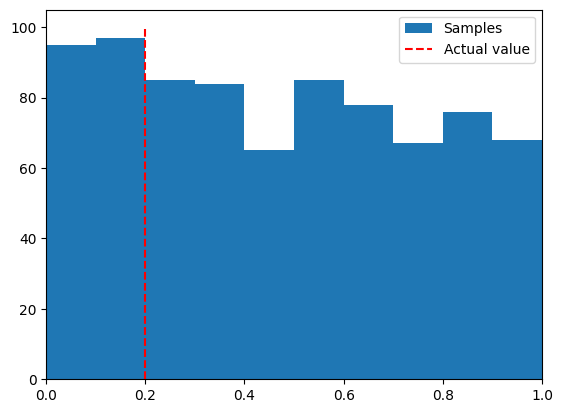

In [ ]:
plt.hist([x[0] for x in samples_rej[0:]], label='Samples')
plt.xlim(0, 1)
plt.vlines(x=0.2, linestyles='dashed', ymin=0, ymax=100, label='Actual value', color='red')
plt.legend()
plt.show()

In [ ]:
problem = pints.SingleOutputProblem(model, times, values=y_draw)
error_measure = RootMSE(problem)
log_prior = pints_jax.UniformLogPrior(0, 1)
abc = pints_jax.ABCController(error_measure, log_prior, method=pints_jax.ABCSMC)
abc.set_parallel(True)

# set threshold schedule
abc.sampler().set_threshold_schedule(np.array([0.53,0.51,0.49]))

# produce intermediate distributions of size 200
# abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(800)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples_smc  = abc.run()
print('Done')

Running...
Using ABC-SMC
Running in parallel with 8 worker processess.
Starting t=0, with threshold=0.53


/var/folders/cg/0j2cykzn1nz90v77l0w8jyhc0000gv/T/ipykernel_59231/3913834773.py:3: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints_jax.UniformLogPrior(0, 1)


Iter. Eval. Acceptance rate Time m:s
1     32     0.0625           0:08.1
2     64     0.0625           0:08.1
3     80     0.0625           0:08.1
20    528    0.0435606061     0:08.3
40    1136   0.0404929577     0:08.5
60    1952   0.0338114754     0:08.8
80    2648   0.0336102719     0:09.1
Starting t=1, with threshold=0.51
100   3360   0.0330357143     0:09.4
120   4064   0.032726378      0:21.2
140   4608   0.033203125      0:21.5
160   5280   0.0329545455     0:21.8
180   6144   0.0319010417     0:22.2
Starting t=2, with threshold=0.49
200   7312   0.0298140044     0:22.7
220   8520   0.0279342723     0:34.2
240   9736   0.0267050123     0:34.7
260   11152  0.025286944      0:35.4
280   12496  0.0246478873     0:47.6
300   13464  0.0243612597     0:48.0
320   14704  0.0237350381     0:48.6
340   15696  0.0235728848     0:49.0
360   16592  0.0235053038     1:00.9
380   17480  0.0236270023     1:01.3
400   18912  0.0229483926     1:02.0
420   20008  0.0226909236     1:12.5
440   2

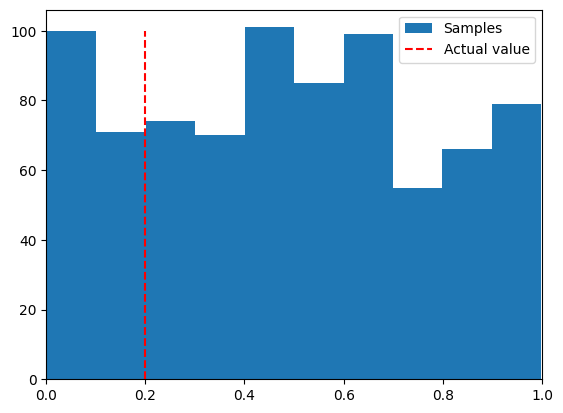

In [ ]:
plt.hist([x[0] for x in samples_smc[0:]], label='Samples')
plt.xlim(0, 1)
plt.vlines(x=0.2, linestyles='dashed', ymin=0, ymax=100, label='Actual value', color='red')
plt.legend()
plt.show()

The threshold for ABC is too high, so results not desirable.